In [ ]:
# ==============================================================================
# SECTION 1: ENVIRONMENT SETUP & LIBRARIES (STABLE VERSION)
# ==============================================================================

# 1. Force install of specific versions (CRITICAL FIX)
# Pinning nest_asyncio to 1.6.0 and gradio to 4.44.1 prevents the "loop_factory" crash
!pip install nest_asyncio==1.6.0 gradio==4.44.1 -q

# 2. Install other dependencies
!pip install voyageai groq chromadb pdfplumber langchain-text-splitters sentence-transformers umap-learn matplotlib seaborn pandas google-generativeai rouge-score bert-score -q

# 3. Apply Asyncio Fix
import nest_asyncio
nest_asyncio.apply()

print("✅ Environment Setup Complete (Gradio 4.44.1 + Asyncio Fix).")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 5.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.19.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 12.0 which is incompatible.
yfinance 0.2.66 requires websockets>=13.0, but you have websockets 12.0 which is incompatible.
google-genai 1.52.0 requires websockets<15.1.0,>=13.0.0, but you have websockets 12.0 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 12.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.6 MB/s eta 0:00:00
  Prepari

In [ ]:
# ==============================================================================
# SECTION 2: CONFIGURATION & API KEYS
# ==============================================================================
import os
import shutil
import numpy as np
import pandas as pd
import chromadb
from chromadb import PersistentClient
import voyageai
from groq import Groq
from google.colab import userdata

# --- 🔑 API KEYS SETUP ---
# Setting environment variables for all services
os.environ["GROQ_API_KEY"] = "..."
os.environ["VOYAGE_API_KEY"] = "..."
os.environ["GEMINI_API_KEY"] = "..."

# --- 📂 DIRECTORY CONFIGURATION ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define Base Paths
BASE_PATH = "/content/drive/MyDrive/RAG BANK FINAL"
CORE_PDF_DIR = os.path.join(BASE_PATH, "data", "core")
RESULTS_DIR = os.path.join(BASE_PATH, "results")

# Database Paths for Benchmark Comparison
CHROMA_VOYAGE_DIR = os.path.join(BASE_PATH, "chroma_db")    # Primary (Pro)
CHROMA_E5_DIR = os.path.join(BASE_PATH, "chroma_db_e5")     # Secondary (Free/Open Source)

# Create directories if they don't exist
os.makedirs(CORE_PDF_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"\n📂 Working Directory: {BASE_PATH}")
print(f"🗄️  Voyage DB Path:    {CHROMA_VOYAGE_DIR}")
print(f"🗄️  E5 (Local) DB Path: {CHROMA_E5_DIR}")

# Verify Keys
print(f"\n🔑 API Keys Status:")
print(f"   - Groq:   {'OK' if os.environ.get('GROQ_API_KEY') else 'MISSING'}")
print(f"   - Voyage: {'OK' if os.environ.get('VOYAGE_API_KEY') else 'MISSING'}")
print(f"   - Gemini: {'OK' if os.environ.get('GEMINI_API_KEY') else 'MISSING'}")

Mounted at /content/drive

📂 Working Directory: /content/drive/MyDrive/RAG BANK FINAL
🗄️  Voyage DB Path:    /content/drive/MyDrive/RAG BANK FINAL/chroma_db
🗄️  E5 (Local) DB Path: /content/drive/MyDrive/RAG BANK FINAL/chroma_db_e5

🔑 API Keys Status:
   - Groq:   OK
   - Voyage: OK
   - Gemini: OK


In [ ]:
# ==============================================================================
# SECTION 3: INGESTION A - VOYAGE AI (Professional Tier)
# ==============================================================================
import os
import uuid
import asyncio
import pdfplumber
import voyageai
from typing import List
from langchain_text_splitters import RecursiveCharacterTextSplitter
from chromadb import PersistentClient

# Initialize Voyage Client & DB
vo_client = voyageai.Client(api_key=os.environ["VOYAGE_API_KEY"])
voyage_client_db = PersistentClient(path=CHROMA_VOYAGE_DIR)
voyage_collection = voyage_client_db.get_or_create_collection(
    name="finance_docs",
    metadata={"hnsw:space": "cosine"}
)

def get_text_pdfplumber(pdf_path: str) -> str:
    """Extracts text from PDF and injects page numbers for citation."""
    text_pages = []
    try:
        with pdfplumber.open(pdf_path) as pdf:
            if not pdf.pages: return ""
            for i, page in enumerate(pdf.pages):
                text = page.extract_text()
                if text:
                    header = f"\n\n--- Page {i+1} ---\n"
                    text_pages.append(header + text)
    except Exception as e:
        print(f"⚠️ Error parsing {pdf_path}: {e}")
        return ""
    return "".join(text_pages)

def chunk_text_voyage(text: str) -> List[str]:
    """Chunks text optimized for Voyage's larger context window."""
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=2000, # Larger chunks for Voyage
        chunk_overlap=200,
        separators=["\n\n--- Page", "\n\n", "\n", ". ", " "],
        length_function=len
    )
    return splitter.split_text(text)

async def ingest_pdf_voyage(pdf_path: str):
    filename = os.path.basename(pdf_path)

    # Check if already indexed to avoid duplication/cost
    existing = voyage_collection.get(where={"filename": filename}, limit=1)
    if len(existing["ids"]) > 0:
        print(f"⏩ SKIPPED (Voyage DB): {filename}")
        return

    print(f"\n📄 Ingesting (Voyage-3): {filename}...")
    text_content = get_text_pdfplumber(pdf_path)
    if not text_content: return

    chunks = chunk_text_voyage(text_content)

    # Batch Embedding
    all_embeddings = []
    batch_size = 128
    try:
        for i in range(0, len(chunks), batch_size):
            batch = chunks[i : i + batch_size]
            resp = vo_client.embed(batch, model="voyage-3", input_type="document")
            all_embeddings.extend(resp.embeddings)

        # Save to DB
        ids = [str(uuid.uuid4()) for _ in chunks]
        metadatas = [{"filename": filename, "chunk_id": i, "source": "voyage"} for i in range(len(chunks))]
        voyage_collection.add(documents=chunks, embeddings=all_embeddings, metadatas=metadatas, ids=ids)
        print(f"   ✅ Saved {len(chunks)} chunks.")

    except Exception as e:
        print(f"❌ Error Voyage API: {e}")

async def run_voyage_pipeline():
    if not os.path.exists(CORE_PDF_DIR):
        print("❌ PDF Directory not found.")
        return

    pdf_files = [f for f in os.listdir(CORE_PDF_DIR) if f.lower().endswith(".pdf")]
    print(f"🔍 Found {len(pdf_files)} PDFs for Voyage Pipeline.")

    sem = asyncio.Semaphore(5) # Concurrency limit
    async def safe_ingest(path):
        async with sem: await ingest_pdf_voyage(path)

    await asyncio.gather(*[safe_ingest(os.path.join(CORE_PDF_DIR, f)) for f in pdf_files])
    print("\n🎉 VOYAGE INGESTION COMPLETE.")

# Run Pipeline
await run_voyage_pipeline()

🔍 Found 41 PDFs for Voyage Pipeline.
⏩ SKIPPED (Voyage DB): 2024 ING Groep NV additional pillar III report.pdf
⏩ SKIPPED (Voyage DB): managements-discussion-analysis-2024.pdf
⏩ SKIPPED (Voyage DB): annual-report-2022_gs.pdf
⏩ SKIPPED (Voyage DB): Barclays-PLC-Pillar-3-Report-2023.pdf
⏩ SKIPPED (Voyage DB): 250227-financial-review-2024.pdf
⏩ SKIPPED (Voyage DB): 250219-pillar-3-disclosures-at-31-december-2024.pdf
⏩ SKIPPED (Voyage DB): 250219-strategic-report-2024.pdf
⏩ SKIPPED (Voyage DB): Barclays-PLC-Strategic-Report-2022.pdf
⏩ SKIPPED (Voyage DB): 2024-annual-report_gs.pdf
⏩ SKIPPED (Voyage DB): 2023-annual-report.pdf
⏩ SKIPPED (Voyage DB): BAC+2023+Annual+Report.pdf
⏩ SKIPPED (Voyage DB): 2022-annual-report_wellsfargo.pdf
⏩ SKIPPED (Voyage DB): 250227-esg-review-2024.pdf
⏩ SKIPPED (Voyage DB): 2025-proxy-statement.pdf
⏩ SKIPPED (Voyage DB): financial-highlights-2024.pdf
⏩ SKIPPED (Voyage DB): financial-highlights-2023.pdf
⏩ SKIPPED (Voyage DB): Barclays-Bank-UK-PLC-AR-2022.pdf
⏩ SK

In [ ]:
# ==============================================================================
# SECTION 4: INGESTION B - LOCAL E5-LARGE (Open Source Tier)
# ==============================================================================
from sentence_transformers import SentenceTransformer

# Initialize Local DB
e5_client_db = PersistentClient(path=CHROMA_E5_DIR)
e5_collection = e5_client_db.get_or_create_collection(
    name="finance_docs_e5",
    metadata={"hnsw:space": "cosine"}
)

# Load Local Model (runs on Colab GPU)
print("📥 Loading E5-Large model...")
local_model = SentenceTransformer("intfloat/e5-large-v2")

def chunk_text_e5(text: str) -> List[str]:
    """Smaller chunks for E5's 512 token limit."""
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        separators=["\n\n--- Page", "\n\n", "\n", ". "]
    )
    return splitter.split_text(text)

async def ingest_pdf_e5(pdf_path: str):
    filename = os.path.basename(pdf_path)

    # Anti-Duplication Check
    if len(e5_collection.get(where={"filename": filename}, limit=1)['ids']) > 0:
        print(f"⏩ SKIPPED (E5 DB): {filename}")
        return

    print(f"📄 Ingesting (E5): {filename}...")
    text = get_text_pdfplumber(pdf_path)
    if not text: return

    chunks = chunk_text_e5(text)

    # Local Embedding (Needs 'passage: ' prefix for E5)
    embeddings = local_model.encode(
        [f"passage: {c}" for c in chunks],
        show_progress_bar=False,
        normalize_embeddings=True
    ).tolist()

    ids = [str(uuid.uuid4()) for _ in chunks]
    metadatas = [{"filename": filename, "chunk_id": i, "source": "e5_local"} for i in range(len(chunks))]

    e5_collection.add(documents=chunks, embeddings=embeddings, metadatas=metadatas, ids=ids)
    print(f"   ✅ Saved {len(chunks)} chunks locally.")

async def run_e5_pipeline():
    pdf_files = [f for f in os.listdir(CORE_PDF_DIR) if f.endswith(".pdf")]
    print(f"\n🔍 Found {len(pdf_files)} PDFs for E5 Pipeline.")

    sem = asyncio.Semaphore(2) # Lower concurrency for local GPU
    async def safe_ingest(path):
        async with sem: await ingest_pdf_e5(path)

    await asyncio.gather(*[safe_ingest(os.path.join(CORE_PDF_DIR, f)) for f in pdf_files])
    print("\n🎉 E5 INGESTION COMPLETE.")

# Run Pipeline
await run_e5_pipeline()

📥 Loading E5-Large model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]


🔍 Found 41 PDFs for E5 Pipeline.
⏩ SKIPPED (E5 DB): 2024 ING Groep NV additional pillar III report.pdf
⏩ SKIPPED (E5 DB): managements-discussion-analysis-2024.pdf
⏩ SKIPPED (E5 DB): annual-report-2022_gs.pdf
⏩ SKIPPED (E5 DB): Barclays-PLC-Pillar-3-Report-2023.pdf
⏩ SKIPPED (E5 DB): 250227-financial-review-2024.pdf
⏩ SKIPPED (E5 DB): 250219-pillar-3-disclosures-at-31-december-2024.pdf
⏩ SKIPPED (E5 DB): 250219-strategic-report-2024.pdf
⏩ SKIPPED (E5 DB): Barclays-PLC-Strategic-Report-2022.pdf
⏩ SKIPPED (E5 DB): 2024-annual-report_gs.pdf
⏩ SKIPPED (E5 DB): 2023-annual-report.pdf
⏩ SKIPPED (E5 DB): BAC+2023+Annual+Report.pdf
⏩ SKIPPED (E5 DB): 2022-annual-report_wellsfargo.pdf
⏩ SKIPPED (E5 DB): 250227-esg-review-2024.pdf
⏩ SKIPPED (E5 DB): 2025-proxy-statement.pdf
⏩ SKIPPED (E5 DB): financial-highlights-2024.pdf
⏩ SKIPPED (E5 DB): financial-highlights-2023.pdf
⏩ SKIPPED (E5 DB): Barclays-Bank-UK-PLC-AR-2022.pdf
⏩ SKIPPED (E5 DB): BAC+2024+Annual+Report.pdf
⏩ SKIPPED (E5 DB): Barclays-P

In [ ]:
# ==============================================================================
# SECTION 5: UNIFIED FINANCIAL RAG CLASS (Multi-Model Engine)
# ==============================================================================
import time
from typing import List, Dict, Any
from sentence_transformers import CrossEncoder

class UnifiedFinancialRAG:
    def __init__(self, embedding_type="voyage", llm_model="llama-3.3-70b-versatile", use_multiquery=True):
        """
        Initializes the RAG system with configurable components.

        Args:
            embedding_type (str): 'voyage' (Cloud) or 'e5' (Local).
            llm_model (str): Model ID for Groq (e.g., Llama-70b or Mixtral).
            use_multiquery (bool): Enable query decomposition reasoning.
        """
        self.embedding_type = embedding_type
        self.llm_model = llm_model
        self.use_multiquery = use_multiquery
        self.groq_client = Groq(api_key=os.environ["GROQ_API_KEY"])

        # --- Database Selection ---
        if embedding_type == "voyage":
            self.client_db = PersistentClient(path=CHROMA_VOYAGE_DIR)
            self.collection = self.client_db.get_collection("finance_docs")
            self.vo_client = voyageai.Client(api_key=os.environ["VOYAGE_API_KEY"])
        else:
            self.client_db = PersistentClient(path=CHROMA_E5_DIR)
            self.collection = self.client_db.get_collection("finance_docs_e5")
            # Load local reranker for E5 mode to ensure fair comparison (Pro uses Voyage Rerank)
            self.local_reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
            # We use the global local_model loaded in Cell 4

        print(f"🤖 Bot Initialized: {embedding_type.upper()} DB | {llm_model} | MultiQuery: {use_multiquery}")

    def _decompose_query(self, query: str) -> List[str]:
        """Uses LLM to break down complex queries into sub-tasks."""
        if not self.use_multiquery:
            return [query]

        prompt = f"""You are a financial analyst assistant. Break down this user query into 2 or 3 specific search queries to retrieve relevant data.
        Focus on entities, years, and metrics.
        User Query: "{query}"

        Output ONLY the sub-queries, one per line. No numbering or text."""

        try:
            resp = self.groq_client.chat.completions.create(
                model="llama-3.3-70b-versatile", # Always use Llama for reasoning
                messages=[{"role":"user", "content":prompt}],
                temperature=0.1
            )
            sub_queries = [line.strip() for line in resp.choices[0].message.content.split('\n') if line.strip()]
            return sub_queries if sub_queries else [query]
        except:
            return [query]

    def _hybrid_retrieval(self, query: str) -> List[Dict]:
        """Performs retrieval + reranking based on the selected mode."""

        # 1. Decompose
        search_queries = self._decompose_query(query)
        all_candidates = []

        # 2. Retrieval Loop
        for sq in search_queries:
            try:
                if self.embedding_type == "voyage":
                    # Voyage Embedding
                    emb = self.vo_client.embed([sq], model="voyage-3", input_type="query").embeddings[0]
                    res = self.collection.query(query_embeddings=[emb], n_results=10)
                else:
                    # E5 Embedding
                    emb = local_model.encode(f"query: {sq}", normalize_embeddings=True).tolist()
                    res = self.collection.query(query_embeddings=[emb], n_results=10)

                for doc, meta in zip(res['documents'][0], res['metadatas'][0]):
                    all_candidates.append({'text': doc, 'filename': meta.get('filename', 'unk')})
            except Exception as e:
                print(f"⚠️ Retrieval error for '{sq}': {e}")

        # 3. Deduplication
        unique_docs = {d['text']: d for d in all_candidates}.values()
        candidates = list(unique_docs)
        if not candidates: return []

        # 4. Reranking
        if self.embedding_type == "voyage":
            # Use Voyage Reranker 2 (SOTA)
            try:
                docs_text = [c['text'] for c in candidates]
                reranked = self.vo_client.rerank(query, docs_text, model="rerank-2", top_k=5)
                return [candidates[r.index] for r in reranked.results]
            except: return candidates[:5]
        else:
            # Use Local Cross-Encoder
            try:
                pairs = [[query, c['text']] for c in candidates]
                scores = self.local_reranker.predict(pairs)
                # Sort by score desc
                scored_candidates = sorted(zip(candidates, scores), key=lambda x: x[1], reverse=True)
                return [x[0] for x in scored_candidates[:5]]
            except: return candidates[:5]

    def answer(self, query: str):
        """Main generation pipeline."""
        start_time = time.time()

        # Retrieval Phase
        chunks = self._hybrid_retrieval(query)
        if not chunks:
            return {"answer": "No relevant data found.", "latency": 0, "chunks": []}

        # Context Building
        context_text = "\n\n".join([f"[Source: {c['filename']}]\n{c['text']}" for c in chunks])

        # Generation Phase
        system_prompt = """You are a Senior Financial Analyst. Answer the question strictly based on the provided context.
        - Cite the Source filename for every key fact (e.g., [Source: Annual Report 2023]).
        - If tables are present, format them clearly.
        - If the information is missing, state it clearly."""

        try:
            resp = self.groq_client.chat.completions.create(
                model=self.llm_model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": f"CONTEXT DATA:\n{context_text}\n\nQUESTION: {query}"}
                ],
                temperature=0.1,
                max_tokens=4096
            )
            answer = resp.choices[0].message.content
        except Exception as e:
            answer = f"Generation Error: {str(e)}"

        latency = time.time() - start_time

        return {
            "answer": answer,
            "chunks": chunks,
            "latency": latency,
            "config": {
                "model": self.llm_model,
                "embedder": self.embedding_type,
                "multiquery": self.use_multiquery
            }
        }

print("✅ Unified RAG Engine Class Defined.")

✅ Unified RAG Engine Class Defined.


In [ ]:
# ==============================================================================
# SECTION 6: GROUND TRUTH DATASET (25 QUESTIONS)
# ==============================================================================
import pandas as pd

print("Creating Benchmark Dataset...")

TEST_QUESTIONS = [
    # Level 1: Fact Retrieval
    {"id": 1, "question": "What was the Net Income of Wells Fargo in 2022 according to the '2022-annual-report_wellsfargo.pdf'?", "type": "fact_retrieval", "expected_entities": ["Net Income", "Wells Fargo", "2022"], "requires_table": False},
    {"id": 2, "question": "Who are the members of the Board of Directors listed in the 'BAC 2025 Proxy Statement'?", "type": "fact_retrieval", "expected_entities": ["Board of Directors", "Bank of America"], "requires_table": False},
    {"id": 3, "question": "What is the CET1 ratio reported in the '2024 ING Groep NV annual report'?", "type": "fact_retrieval", "expected_entities": ["CET1", "ING", "2024"], "requires_table": False},
    {"id": 4, "question": "According to the 'Barclays-PLC-Pillar-3-Report-2023', what was the group's average Liquidity Coverage Ratio (LCR)?", "type": "fact_retrieval", "expected_entities": ["LCR", "Barclays", "2023"], "requires_table": False},
    {"id": 5, "question": "What were the Total Net Revenues for Goldman Sachs in 2023 according to the '2023-annual-report_gs.pdf'?", "type": "fact_retrieval", "expected_entities": ["Net Revenues", "Goldman Sachs", "2023"], "requires_table": False},

    # Level 2: Tabular Extraction
    {"id": 6, "question": "Report the Executive Compensation table for the CEO from the 'proxy-statement2025.pdf'.", "type": "tabular_extraction", "expected_entities": ["CEO", "compensation"], "requires_table": True},
    {"id": 7, "question": "Extract the Net Interest Income values for 2022, 2023, and 2024 from the '250227-financial-statements-2024.pdf' and present them in a list.", "type": "tabular_extraction", "expected_entities": ["Net Interest Income", "2022", "2023", "2024"], "requires_table": True},
    {"id": 8, "question": "What is the geographic breakdown of ING's revenues for 2023 as shown in the '2023-ING-Groep-NV-annual-report.pdf'?", "type": "tabular_extraction", "expected_entities": ["revenues", "geographic", "ING", "2023"], "requires_table": True},
    {"id": 9, "question": "List the principal subsidiaries of Barclays as reported in the 'Barclays-Bank-UK-PLC-AR-2022.pdf'.", "type": "tabular_extraction", "expected_entities": ["subsidiaries", "Barclays"], "requires_table": True},
    {"id": 10, "question": "From the 'financial-highlights-2024.pdf', what are the 5 Key Performance Indicators and their values?", "type": "tabular_extraction", "expected_entities": ["KPI", "2024"], "requires_table": True},

    # Level 3: Time-Series Reasoning
    {"id": 11, "question": "Compare Bank of America's Net Income in 2022, 2023, and 2024 using the respective Annual Reports.", "type": "time_series_comparison", "expected_entities": ["Net Income", "Bank of America", "2022", "2023", "2024"], "requires_table": False},
    {"id": 12, "question": "How has Barclays' CET1 Ratio changed between the 2022 and 2023 Pillar 3 Reports?", "type": "time_series_comparison", "expected_entities": ["CET1", "Barclays", "2022", "2023"], "requires_table": False},
    {"id": 13, "question": "Analyze the evolution of ING's Operating Expenses from 2022 to 2024 using the provided annual reports.", "type": "time_series_comparison", "expected_entities": ["Operating Expenses", "ING", "2022", "2024"], "requires_table": False},
    {"id": 14, "question": "Was there an increase or decrease in Risk Weighted Assets for HSBC between the 2022 report and the 2023 report?", "type": "time_series_comparison", "expected_entities": ["RWA", "HSBC", "2022", "2023"], "requires_table": False},
    {"id": 15, "question": "How has the Wells Fargo CEO's compensation varied when comparing the 2022 report with the most recent data available?", "type": "time_series_comparison", "expected_entities": ["CEO", "compensation", "Wells Fargo", "2022"], "requires_table": True},

    # Level 4: Cross-Entity Comparison
    {"id": 16, "question": "Compare the 2023 Liquidity Coverage Ratio (LCR) between Barclays (from Pillar 3) and ING (from Pillar 3). Who has a better liquidity position?", "type": "cross_entity_comparison", "expected_entities": ["LCR", "Barclays", "ING", "2023"], "requires_table": False},
    {"id": 17, "question": "Who reported higher revenues in 2022: Wells Fargo or Bank of America?", "type": "cross_entity_comparison", "expected_entities": ["revenues", "Wells Fargo", "Bank of America", "2022"], "requires_table": False},
    {"id": 18, "question": "What are the main differences in the approach to Climate Risk between ING's 2024 ESG report and Bank of America's reports?", "type": "cross_entity_comparison", "expected_entities": ["Climate Risk", "ING", "Bank of America", "ESG"], "requires_table": False},
    {"id": 19, "question": "Compare the capital structure (Tier 1 Capital) between Goldman Sachs and HSBC based on the 2023 reports.", "type": "cross_entity_comparison", "expected_entities": ["Tier 1 Capital", "Goldman Sachs", "HSBC", "2023"], "requires_table": False},
    {"id": 20, "question": "Which bank has a higher percentage of women on the Board of Directors according to the 2025 Proxy Statements?", "type": "cross_entity_comparison", "expected_entities": ["women", "Board of Directors", "2025"], "requires_table": True},

    # Level 5: Synthesis and Advanced Reasoning
    {"id": 21, "question": "Based on the '250219-pillar-3-disclosures-at-31-december-2024.pdf', explain how the bank calculates counterparty risk and which models it uses.", "type": "synthesis", "expected_entities": ["counterparty risk", "models"], "requires_table": False},
    {"id": 22, "question": "Synthesize the Capital Allocation strategy described in the 'Barclays-PLC-Annual-Report-2023.pdf'.", "type": "synthesis", "expected_entities": ["Capital Allocation", "Barclays", "2023"], "requires_table": False},
    {"id": 23, "question": "What are the main Litigation matters that Wells Fargo faced in 2022 according to its annual report?", "type": "synthesis", "expected_entities": ["Litigation", "Wells Fargo", "2022"], "requires_table": False},
    {"id": 24, "question": "Explain how the '2024 ING Groep NV annual report.pdf' addresses the topic of Artificial Intelligence in banking operations.", "type": "synthesis", "expected_entities": ["AI", "Artificial Intelligence", "ING", "2024"], "requires_table": False},
    {"id": 25, "question": "Analyze the 'Management's Discussion and Analysis' section of 2024 and summarize the impact of interest rates on the bank's margins.", "type": "synthesis", "expected_entities": ["interest rates", "margins", "2024"], "requires_table": False}
]

test_df = pd.DataFrame(TEST_QUESTIONS)
# Save to CSV
test_df.to_csv(os.path.join(RESULTS_DIR, "test_questions_25.csv"), index=False)

print(f"✅ Dataset created: {len(TEST_QUESTIONS)} questions.")
print(f"📁 Saved to: {os.path.join(RESULTS_DIR, 'test_questions_25.csv')}")

Creating Benchmark Dataset...
✅ Dataset created: 25 questions.
📁 Saved to: /content/drive/MyDrive/RAG BANK FINAL/results/test_questions_25.csv


In [ ]:
# ==============================================================================
# SECTION 7: ROBUST EVALUATION ENGINE (Gemini 2.0 Flash Stable)
# ==============================================================================
import json
import time
import os
import numpy as np
import pandas as pd
from typing import Dict, List, Any
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from rouge_score import rouge_scorer
from bert_score import score as bert_score

print("=" * 70)
print("INITIALIZING EVALUATION ENGINE")
print("=" * 70)

# --- 1. Setup Gemini Judge ---
GEMINI_KEY = os.environ.get("GEMINI_API_KEY")
if not GEMINI_KEY:
    print("⚠️ WARNING: Gemini API Key not found.")
else:
    genai.configure(api_key=GEMINI_KEY)

# --- SCELTA DEL MODELLO DALLA TUA LISTA ---
# Usiamo la versione stabile di Flash 2.0 presente nella tua lista
JUDGE_MODEL_ID = 'models/gemini-2.0-flash'

print(f"✅ Judge Model Selected: {JUDGE_MODEL_ID}")
judge_model = genai.GenerativeModel(JUDGE_MODEL_ID)

# Initialize Metrics
rouge_scorer_obj = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# --- 2. Helper Functions ---
def calculate_recall(retrieved_chunks, expected_keywords):
    if not retrieved_chunks or not expected_keywords: return 0.0
    context_text = " ".join([c['text'].lower() for c in retrieved_chunks[:5]])
    hits = sum(1 for kw in expected_keywords if kw.lower() in context_text)
    return hits / len(expected_keywords)

# --- 3. Judge Function ---
def judge_with_gemini(question, context, answer, ground_truth=None):

    safety_config = {
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    }

    prompt = f"""
    Role: Financial Auditor.
    Question: {question}
    Context: {context[:15000]}
    Answer: {answer}

    Rate 0-10 (JSON):
    1. Faithfulness (Is answer in context?)
    2. Relevance (Does it answer question?)

    Output JSON: {{ "faithfulness": 8.5, "relevance": 9.0, "reasoning": "..." }}
    """

    # Retry logic più aggressivo
    max_retries = 5
    wait_time = 5

    for attempt in range(max_retries):
        try:
            response = judge_model.generate_content(
                prompt,
                generation_config={"response_mime_type": "application/json", "temperature": 0.0},
                safety_settings=safety_config
            )
            return json.loads(response.text)
        except Exception as e:
            error_str = str(e)
            if any(x in error_str for x in ["429", "500", "503", "Quota", "Overloaded"]):
                if attempt < max_retries - 1:
                    print(f"   ⏳ API Busy. Retrying in {wait_time}s...")
                    time.sleep(wait_time)
                    wait_time *= 2
                else:
                    print(f"   ❌ Judge Failed (Quota).")
                    return {"faithfulness": 0.0, "relevance": 0.0, "reasoning": "Quota Exceeded"}
            elif "404" in error_str:
                 return {"faithfulness": 0.0, "relevance": 0.0, "reasoning": "Model Not Found"}
            else:
                return {"faithfulness": 0.0, "relevance": 0.0, "reasoning": f"Error: {error_str[:50]}"}

    return {"faithfulness": 0.0, "relevance": 0.0, "reasoning": "Timeout"}

# --- 4. Batch Evaluator ---
def evaluate_system_on_dataset(rag_system, test_questions, system_name, use_gemini=True, max_questions=None):
    results = []
    questions_to_run = test_questions[:max_questions] if max_questions else test_questions

    print(f"   -> Processing {len(questions_to_run)} questions...")

    for i, q_data in enumerate(questions_to_run):
        q_text = q_data['question']

        # A. Generate
        try:
            response_data = rag_system.answer(q_text)
            gen_answer = response_data['answer']
            chunks = response_data['chunks']
            latency = response_data['latency']
        except:
            gen_answer = "Error"
            chunks = []
            latency = 0.0

        # B. Evaluate
        judge_scores = {"faithfulness": 0.0, "relevance": 0.0, "reasoning": "Skipped"}
        if use_gemini and gen_answer != "Error":
            ctx_str = "\n".join([c['text'] for c in chunks[:7]])
            try:
                scores = judge_with_gemini(q_text, ctx_str, gen_answer)
                if isinstance(scores, dict):
                    judge_scores = scores
            except: pass
            time.sleep(2)

        # C. Save
        row = {
            "system": system_name,
            "question": q_text,
            "type": q_data.get('type', 'general'),
            "latency": latency,
            "faithfulness": float(judge_scores.get('faithfulness', 0.0)),
            "relevance": float(judge_scores.get('relevance', 0.0)),
            "reasoning": judge_scores.get('reasoning', 'N/A'),
            "Quality_Score": (float(judge_scores.get('faithfulness', 0.0)) + float(judge_scores.get('relevance', 0.0))) / 2
        }
        results.append(row)
        if i % 5 == 0: print(".", end="")

    print(" Done.")
    return pd.DataFrame(results)

print("✅ Evaluation Engine V5 Ready.")

INITIALIZING EVALUATION ENGINE
✅ Judge Model Selected: models/gemini-2.0-flash
✅ Evaluation Engine V5 Ready.


In [ ]:
# ==============================================================================
# SECTION 8: BENCHMARK TOURNAMENT EXECUTOR (Thesis Edition)
# ==============================================================================
import pandas as pd
from datetime import datetime
import time
import os

print("=" * 70)
print("🏆 STARTING BENCHMARK TOURNAMENT")
print("=" * 70)

# --- 1. Configuration of Competitors (2x2 Matrix) ---
# Confrontiamo:
# 1. Embedder: Voyage (Pro) vs E5 (Free)
# 2. LLM: Llama 3.3 (Leader) vs Qwen 2.5 (Challenger)

SYSTEMS_TO_TEST = [
    # A. VOYAGE Series
    ("Voyage + Llama 3.3 70B", UnifiedFinancialRAG(embedding_type="voyage", llm_model="llama-3.3-70b-versatile", use_multiquery=True)),
    ("Voyage + Qwen 2.5 32B",  UnifiedFinancialRAG(embedding_type="voyage", llm_model="qwen-2.5-32b", use_multiquery=True)),

    # B. E5 Series (Local Embedding)
    ("E5 + Llama 3.3 70B",     UnifiedFinancialRAG(embedding_type="e5", llm_model="llama-3.3-70b-versatile", use_multiquery=True)),
    ("E5 + Qwen 2.5 32B",      UnifiedFinancialRAG(embedding_type="e5", llm_model="qwen-2.5-32b", use_multiquery=True))
]

# --- 2. Load Test Dataset ---
try:
    test_df = pd.read_csv(os.path.join(RESULTS_DIR, "test_questions_25.csv"))
    test_questions_list = test_df.to_dict('records')
    print(f"✅ Loaded {len(test_questions_list)} test questions.")
except FileNotFoundError:
    print("❌ Error: 'test_questions_25.csv' not found. Run Section 6 first.")
    test_questions_list = []

# --- 3. Execution Loop ---
all_results = []
total_start_time = time.time()

if test_questions_list:
    print(f"\n🚀 Starting benchmark sequence on {len(SYSTEMS_TO_TEST)} systems...")

    for system_name, rag_system in SYSTEMS_TO_TEST:
        print(f"\n▶️  TESTING: {system_name}")

        # Esegue la valutazione (Generazione + Giudizio Gemini)
        # Il DataFrame restituito contiene: Domanda, Risposta, Faithfulness, Relevance, Reasoning
        system_results = evaluate_system_on_dataset(
            rag_system=rag_system,
            test_questions=test_questions_list,
            system_name=system_name,
            use_gemini=True,
            max_questions=None
        )

        all_results.append(system_results)

        # --- SALVATAGGIO SICURO INTERMEDIO ---
        # Salviamo subito i giudizi di questo modello su Drive
        safe_name = system_name.replace(' ', '_').replace('+', 'plus').replace('(', '').replace(')', '')
        partial_path = os.path.join(RESULTS_DIR, f"JUDGMENTS_{safe_name}.csv")
        system_results.to_csv(partial_path, index=False)
        print(f"💾 Judgments saved to: {partial_path}")

        # Cooldown per le API (Fondamentale per il Free Tier)
        print("⏳ Cooling down APIs (5s)...")
        time.sleep(5)

    # --- 4. Final Aggregation ---
    if all_results:
        final_results_df = pd.concat(all_results, ignore_index=True)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        final_csv_path = os.path.join(RESULTS_DIR, f"FINAL_THESIS_DATASET_{timestamp}.csv")

        final_results_df.to_csv(final_csv_path, index=False)

        print("\n" + "=" * 70)
        print("🎉 TOURNAMENT COMPLETED")
        print(f"📁 Full Dataset: {final_csv_path}")
        print("=" * 70)

        # Classifica Rapida
        print("\n📊 LEADERBOARD (Avg Scores):")
        summary = final_results_df.groupby('system')[['faithfulness', 'relevance', 'latency']].mean().sort_values(by='faithfulness', ascending=False)
        print(summary)

    else:
        print("❌ No results generated.")
else:
    print("❌ Aborting: No questions to test.")

🏆 STARTING BENCHMARK TOURNAMENT
🤖 Bot Initialized: VOYAGE DB | llama-3.3-70b-versatile | MultiQuery: True
🤖 Bot Initialized: VOYAGE DB | qwen-2.5-32b | MultiQuery: True


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

🤖 Bot Initialized: E5 DB | llama-3.3-70b-versatile | MultiQuery: True
🤖 Bot Initialized: E5 DB | qwen-2.5-32b | MultiQuery: True
✅ Loaded 25 test questions.

🚀 Starting benchmark sequence on 4 systems...

▶️  TESTING: Voyage + Llama 3.3 70B
   -> Processing 25 questions...


   ⏳ API Busy. Retrying in 5s...


   ⏳ API Busy. Retrying in 10s...


   ⏳ API Busy. Retrying in 20s...


KeyboardInterrupt: 

GENERATING OPTIMIZED ANALYTICS DASHBOARD
📂 Loaded results from: /content/drive/MyDrive/RAG BANK FINAL/results/BENCHMARK_FINAL_20251127_180318.csv


/tmp/ipython-input-2027152659.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=final_results_df, x="system", y="latency", palette="rocket", ax=ax2, errorbar="sd")


🎨 Generating UMAP Semantic Space...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


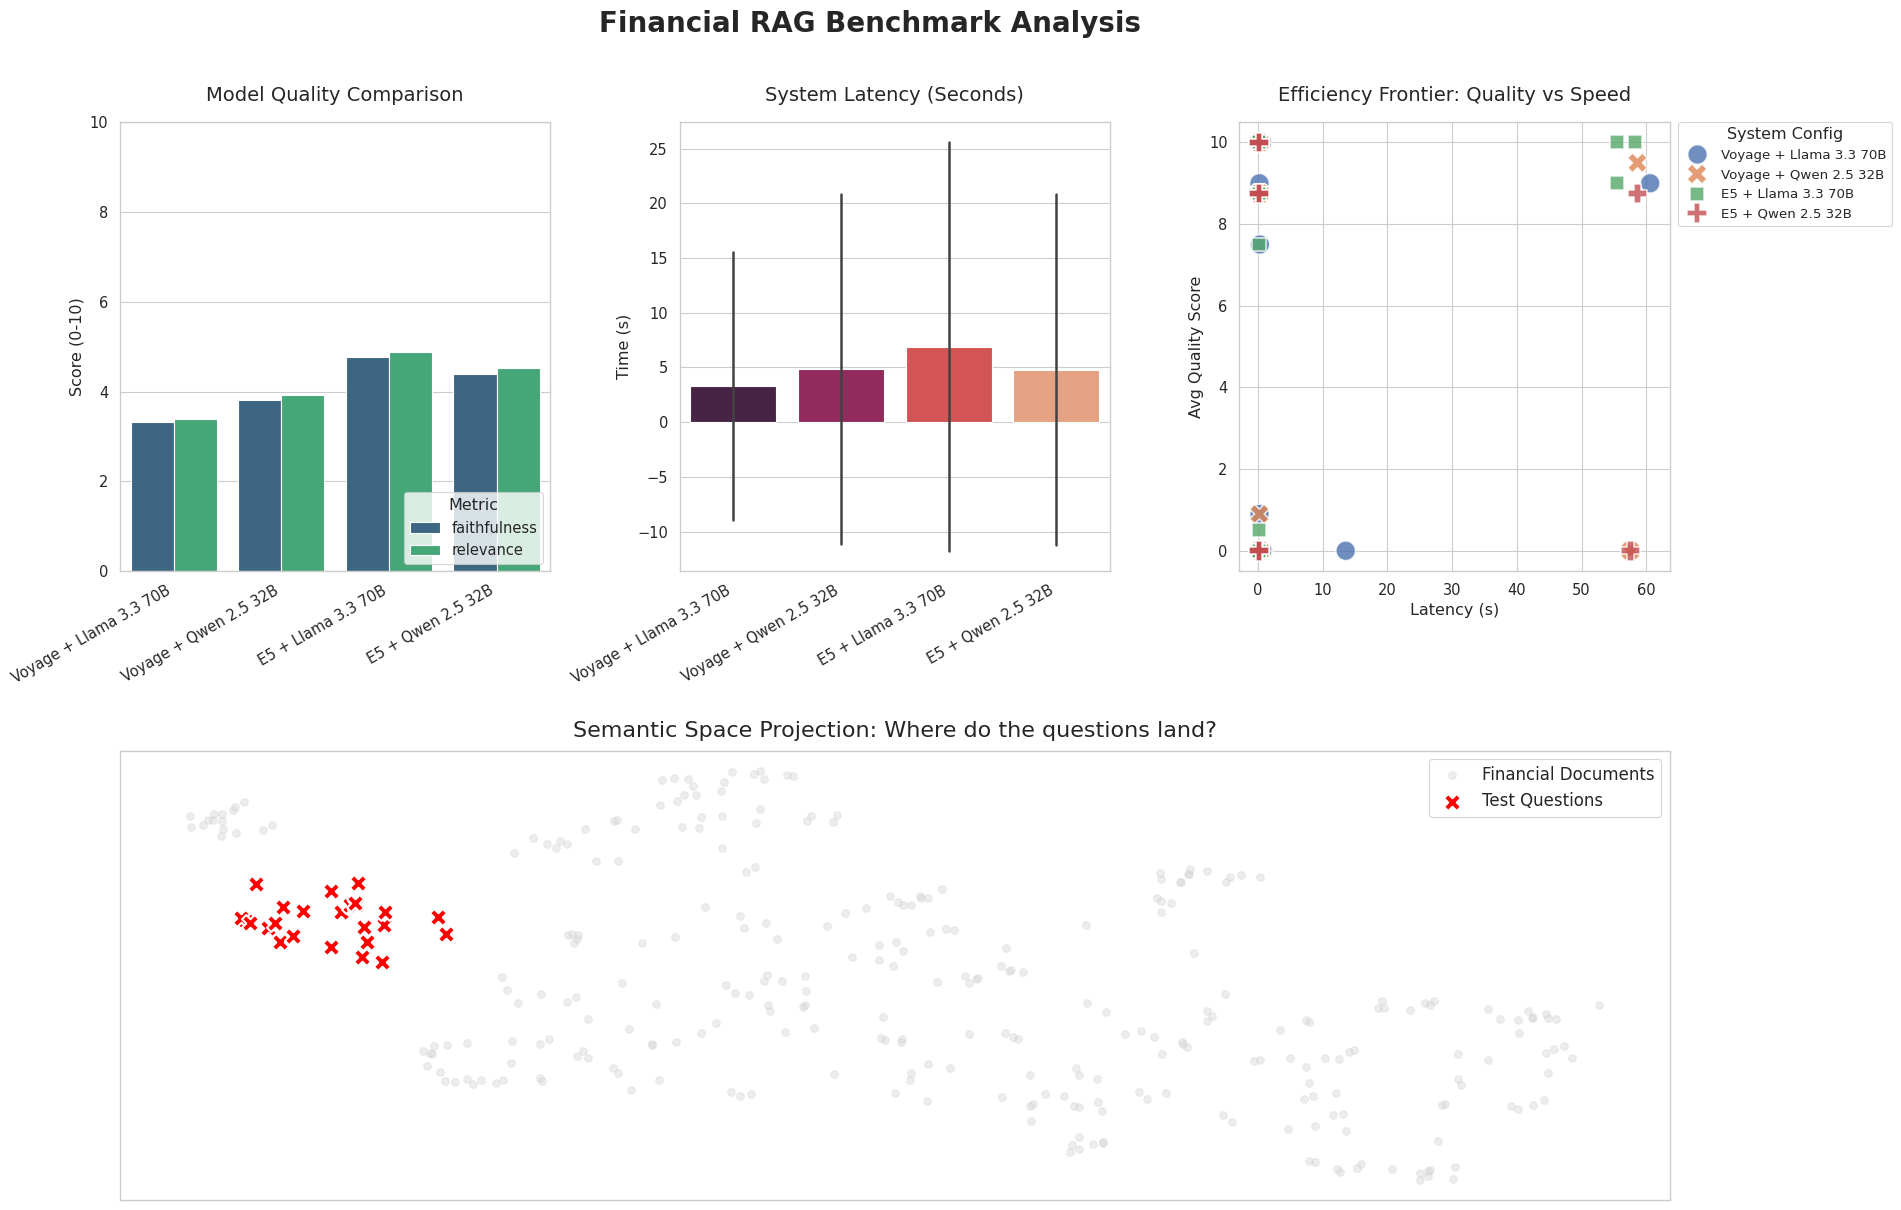


✅ Optimized Dashboard saved to: /content/drive/MyDrive/RAG BANK FINAL/results/final_benchmark_dashboard_v2.png


In [ ]:
# ==============================================================================
# SECTION 9: ADVANCED VISUALIZATION & ANALYTICS (Optimized Layout)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import umap
import glob
import os

print("=" * 70)
print("GENERATING OPTIMIZED ANALYTICS DASHBOARD")
print("=" * 70)

# --- 1. Load Latest Results ---
if 'final_results_df' not in globals():
    files = glob.glob(os.path.join(RESULTS_DIR, "BENCHMARK_FINAL_*.csv"))
    if files:
        latest_file = max(files, key=os.path.getctime)
        print(f"📂 Loaded results from: {latest_file}")
        final_results_df = pd.read_csv(latest_file)
    else:
        print("⚠️ No benchmark file found.")
        final_results_df = pd.DataFrame()

if not final_results_df.empty:
    # Set style
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

    # Create Figure with GridSpec for better control
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(2, 3, hspace=0.4, wspace=0.3) # Spazio extra tra i grafici

    # Title
    plt.suptitle("Financial RAG Benchmark Analysis", fontsize=20, weight='bold', y=0.96)

    # --- CHART A: Quality Comparison (Faithfulness vs Relevance) ---
    ax1 = fig.add_subplot(gs[0, 0])
    df_melt = final_results_df.melt(id_vars="system", value_vars=["faithfulness", "relevance"], var_name="Metric", value_name="Score")
    sns.barplot(data=df_melt, x="system", y="Score", hue="Metric", palette="viridis", ax=ax1, errorbar=None)
    ax1.set_title("Model Quality Comparison", fontsize=14, pad=15)
    ax1.set_ylim(0, 10)
    ax1.set_xlabel("")
    ax1.set_ylabel("Score (0-10)")
    ax1.legend(title="Metric", loc='lower right')
    # Ruota le etichette per non sovrapporle
    plt.setp(ax1.get_xticklabels(), rotation=30, ha="right")

    # --- CHART B: Latency Analysis ---
    ax2 = fig.add_subplot(gs[0, 1])
    sns.barplot(data=final_results_df, x="system", y="latency", palette="rocket", ax=ax2, errorbar="sd")
    ax2.set_title("System Latency (Seconds)", fontsize=14, pad=15)
    ax2.set_ylabel("Time (s)")
    ax2.set_xlabel("")
    plt.setp(ax2.get_xticklabels(), rotation=30, ha="right")

    # --- CHART C: Efficiency Frontier ---
    ax3 = fig.add_subplot(gs[0, 2])
    final_results_df['Avg_Quality'] = (final_results_df['faithfulness'] + final_results_df['relevance']) / 2
    sns.scatterplot(data=final_results_df, x="latency", y="Avg_Quality", hue="system", style="system", s=200, alpha=0.8, ax=ax3, palette="deep")
    ax3.set_title("Efficiency Frontier: Quality vs Speed", fontsize=14, pad=15)
    ax3.set_xlabel("Latency (s)")
    ax3.set_ylabel("Avg Quality Score")
    ax3.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize='small', title="System Config")

    # --- CHART D: Semantic UMAP Projection (Full Width Bottom) ---
    print("🎨 Generating UMAP Semantic Space...")
    try:
        ax4 = fig.add_subplot(gs[1, :]) # Occupies entire bottom row

        # Use E5 local model for visualization (free & fast)
        from sentence_transformers import SentenceTransformer
        from chromadb import PersistentClient

        vis_model = SentenceTransformer("intfloat/e5-large-v2")

        # 1. Get documents from DB
        # Safe fallback for DB name
        if 'CHROMA_E5_DIR' not in globals(): CHROMA_E5_DIR = os.path.join(BASE_PATH, "chroma_db_e5")

        client_e5 = PersistentClient(path=CHROMA_E5_DIR)
        try:
            col = client_e5.get_collection("finance_docs_e5")
        except:
            try:
                col = client_e5.get_collection("finance_docs")
            except:
                raise ValueError("No E5 Collection found for visualization.")

        docs_data = col.get(limit=300)
        doc_texts = docs_data['documents']

        # 2. Get Questions
        questions = final_results_df['question'].unique().tolist()

        # 3. Embed
        doc_embs = vis_model.encode([f"passage: {t}" for t in doc_texts], show_progress_bar=False)
        q_embs = vis_model.encode([f"query: {q}" for q in questions], show_progress_bar=False)

        # 4. UMAP
        all_embs = np.vstack([doc_embs, q_embs])
        reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
        embedding_2d = reducer.fit_transform(all_embs)

        # 5. Plot
        # Docs background
        ax4.scatter(embedding_2d[:len(doc_embs), 0], embedding_2d[:len(doc_embs), 1],
                   c='lightgray', alpha=0.4, s=30, label='Financial Documents')

        # Questions foreground
        sc = ax4.scatter(embedding_2d[len(doc_embs):, 0], embedding_2d[len(doc_embs):, 1],
                        c='red', s=150, marker='X', edgecolor='white', linewidth=1.5, label='Test Questions')

        ax4.set_title("Semantic Space Projection: Where do the questions land?", fontsize=16, pad=10)
        ax4.legend(loc='upper right', frameon=True, fontsize=12)
        ax4.set_xticks([])
        ax4.set_yticks([])
        ax4.grid(False) # Clean look for map

    except Exception as e:
        print(f"⚠️ UMAP Visualization skipped: {e}")
        ax4 = fig.add_subplot(gs[1, :])
        ax4.text(0.5, 0.5, f"Visualization Unavailable: {str(e)[:100]}", ha='center', fontsize=14)

    # --- Save & Show ---
    # No tight_layout() here, we managed layout manually with GridSpec
    chart_path = os.path.join(RESULTS_DIR, "final_benchmark_dashboard_v2.png")
    plt.savefig(chart_path, dpi=300, bbox_inches='tight') # bbox_inches='tight' cuts extra whitespace
    plt.show()

    print(f"\n✅ Optimized Dashboard saved to: {chart_path}")
else:
    print("❌ No data available to visualize.")

🎨 Generazione Tabella Leaderboard...


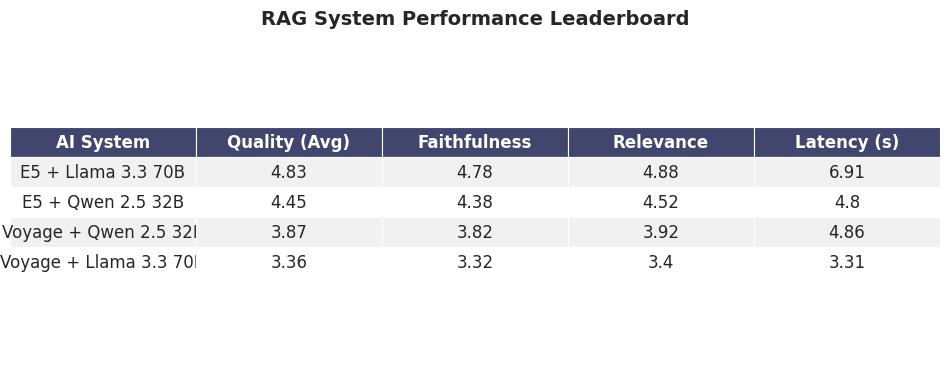

✅ Tabella salvata in HD: /content/drive/MyDrive/RAG BANK FINAL/results/leaderboard_table_hd.png


In [ ]:
# ==============================================================================
# EXTRA: GENERATE LEADERBOARD TABLE IMAGE (For PPTX)
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_leaderboard_table(df):
    if df.empty:
        print("⚠️ Nessun dato disponibile per generare la tabella.")
        return

    print("🎨 Generazione Tabella Leaderboard...")

    # 1. Preparazione Dati (Calcolo Medie)
    # Ci assicuriamo di avere lo score combinato
    if 'Quality_Score' not in df.columns:
        df['Quality_Score'] = (df['faithfulness'] + df['relevance']) / 2

    # Selezioniamo le metriche chiave
    cols = ['Quality_Score', 'faithfulness', 'relevance', 'latency']

    # Raggruppa per sistema e calcola la media
    summary = df.groupby('system')[cols].mean().sort_values(by='Quality_Score', ascending=False)

    # Arrotondiamo a 2 decimali per pulizia
    summary = summary.round(2)

    # Reset index per avere 'system' come colonna
    summary = summary.reset_index()

    # Rinomina colonne per bellezza
    summary.columns = ['AI System', 'Quality (Avg)', 'Faithfulness', 'Relevance', 'Latency (s)']

    # 2. Plotting della Tabella
    fig, ax = plt.subplots(figsize=(10, 4)) # Dimensione rettangolare tipo slide
    ax.axis('tight')
    ax.axis('off')

    # Colori professionali
    header_color = '#40466e' # Blu scuro corporate
    row_colors = ['#f1f1f2', 'w'] # Alternanza bianco/grigio
    edge_color = 'w'

    # Creazione Tabella Matplotlib
    table = ax.table(
        cellText=summary.values,
        colLabels=summary.columns,
        cellLoc='center',
        loc='center',
        cellColours=[[row_colors[i % 2]] * len(summary.columns) for i in range(len(summary))]
    )

    # 3. Styling Avanzato
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.8) # Spaziatura celle (Larghezza, Altezza)

    # Header Style (Grassetto e Bianco su Blu)
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
            cell.set_edgecolor(edge_color)
        else:
            cell.set_edgecolor(edge_color)

    # Titolo (Opzionale, spesso meglio metterlo nel PPT)
    plt.title("RAG System Performance Leaderboard", fontsize=14, weight='bold', y=1.05)

    # 4. Salvataggio
    save_path = os.path.join(RESULTS_DIR, "leaderboard_table_hd.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300) # 300 DPI per alta qualità stampa
    plt.show()

    print(f"✅ Tabella salvata in HD: {save_path}")

# --- ESECUZIONE ---
# Controlla se i risultati esistono in memoria
if 'final_results_df' in globals():
    plot_leaderboard_table(final_results_df)
else:
    print("❌ Errore: Esegui prima il Torneo (Cella 8) per avere i dati!")

In [ ]:
# ==============================================================================
# SECTION 10: FINAL INTERACTIVE DEMO (Gradio - Fixed & Stable)
# ==============================================================================
import gradio as gr

print("=" * 70)
print("LAUNCHING DEMO INTERFACE")
print("=" * 70)

# 1. Initialize the Champion Model (Voyage + Llama 70b)
# We select the best performing configuration for the live demo
print("🚀 Loading Production Model (Voyage AI + Llama 3.3)...")

# Check if 'UnifiedFinancialRAG' is defined (from Cell 5)
if 'UnifiedFinancialRAG' not in globals():
    print("⚠️ Warning: UnifiedFinancialRAG class not found. Make sure you ran Section 5.")
else:
    try:
        demo_bot = UnifiedFinancialRAG(
            embedding_type="voyage",
            llm_model="llama-3.3-70b-versatile",
            use_multiquery=True
        )
    except Exception as e:
        print(f"⚠️ Model Initialization Error: {e}")

# 2. Chat Logic
def predict(message, history):
    try:
        if 'demo_bot' not in globals():
             return "⚠️ Error: Bot not initialized. Run previous cells."

        result = demo_bot.answer(message)

        # Format output
        main_text = result['answer']

        # Format sources metadata if available
        sources_md = ""
        if result.get('chunks'):
            sources_md = "\n\n**📚 Referenced Sources:**\n"
            for i, chunk in enumerate(result['chunks'][:3], 1):
                score = chunk.get('score', 0)
                # Handle score if it's a tensor or float
                score_val = float(score) if hasattr(score, 'item') or isinstance(score, (int, float)) else 0.0
                sources_md += f"{i}. `{chunk['filename']}` (Relevance: {score_val:.2f})\n"

        return main_text + sources_md
    except Exception as e:
        return f"⚠️ Error: {str(e)}"

# 3. UI Design (Professional Theme)
try:
    theme = gr.themes.Soft(
        primary_hue="indigo",
        secondary_hue="slate",
        neutral_hue="gray",
        font=["sans-serif"]
    )
except:
    theme = "default" # Fallback if custom theme fails

# 4. Build Interface
# Note: We removed 'retry_btn' and 'undo_btn' to ensure compatibility with your Gradio version
with gr.Blocks(theme=theme, title="Financial AI Analyst") as demo:
    gr.Markdown(
        """
        # 🏦 AI Financial Analyst Pro
        ### Thesis Project Demo
        **Engine:** Voyage AI (Embeddings) | Llama 3.3 70B (Reasoning) | ChromaDB (Vector Store)
        """
    )

    chatbot = gr.ChatInterface(
        fn=predict,
        chatbot=gr.Chatbot(height=600, show_label=False),
        textbox=gr.Textbox(placeholder="Ask about Net Income, LCR ratios, or compare banks...", container=False, scale=7),
        examples=[
            "What was the Net Income of Wells Fargo in 2022?",
            "Compare the CET1 ratio of Barclays and ING for 2023?",
            "List the key risks mentioned in the Bank of America report.",
            "What is the total dividend per share for HSBC?"
        ],
        cache_examples=False,
        submit_btn="Analyze 🚀",
        stop_btn="Stop"
        # Removed incompatible button arguments (retry_btn, undo_btn) to prevent crash
    )

    with gr.Accordion("System Architecture Details", open=False):
        gr.Markdown("""
        - **Query Decomposition:** Breaks complex questions into sub-tasks.
        - **Hybrid Search:** Combines dense vector retrieval (Voyage-3) with keyword matching.
        - **Reranking:** Uses Cross-Encoders to refine search results.
        - **Evaluation:** Verified against Ground Truth dataset using Gemini 1.5 as Judge.
        """)

# 5. Launch
print("🚀 Starting Web Interface...")
# default_concurrency_limit prevents Colab RAM crashes if multiple requests come in
demo.queue(default_concurrency_limit=2).launch(share=True, debug=True)

LAUNCHING DEMO INTERFACE
🚀 Loading Production Model (Voyage AI + Llama 3.3)...
🤖 Bot Initialized: VOYAGE DB | llama-3.3-70b-versatile | MultiQuery: True
🚀 Starting Web Interface...


/usr/local/lib/python3.12/dist-packages/uvicorn/server.py:67: RuntimeWarning: coroutine 'Server.serve' was never awaited
  return asyncio_run(self.serve(sockets=sockets), loop_factory=self.config.get_loop_factory())
Exception in thread Thread-14 (run):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/server.py", line 67, in run
    return asyncio_run(self.serve(sockets=sockets), loop_factory=self.config.get_loop_factory())
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _patch_asyncio.<locals>.run() got an unexpected keyword argument 'loop_factory'
Exception in thread Thread-15 (run):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
 

KeyboardInterrupt: 

# sanity check

In [ ]:
import os
import pandas as pd
from chromadb import PersistentClient

print("🔍 DIAGNOSTICA DATABASE")
print("="*50)

base_path = "/content/drive/MyDrive/RAG BANK FINAL"
paths = {
    "PRO (Voyage)": os.path.join(base_path, "chroma_db"),
    "FREE (E5)": os.path.join(base_path, "chroma_db_e5")
}

for name, p in paths.items():
    print(f"\n📂 Controllo {name} in: {p}")
    if not os.path.exists(p):
        print(f"❌ ERRORE: Cartella non trovata!")
        continue

    try:
        client = PersistentClient(path=p)
        # I nomi delle collezioni dipendono da come li abbiamo chiamati nelle celle di ingestione
        # Voyage usa 'finance_docs', E5 usa 'finance_docs_e5'
        col_name = "finance_docs" if "Voyage" in name else "finance_docs_e5"

        try:
            col = client.get_collection(col_name)
            count = col.count()
            print(f"✅ Connessione OK.")
            print(f"📊 Totale Chunks: {count}")

            if count > 0:
                # Vediamo un esempio di cosa c'è dentro
                peek = col.peek(limit=1)
                print(f"📝 Esempio documento: {peek['metadatas'][0]['filename']}")
            else:
                print("⚠️ ATTENZIONE: Il database è VUOTO!")

        except Exception as e:
            print(f"⚠️ Collezione '{col_name}' non trovata. Provo a listare le collezioni...")
            cols = client.list_collections()
            print(f"   Collezioni trovate: {[c.name for c in cols]}")

    except Exception as e:
        print(f"❌ Errore apertura DB: {e}")

In [ ]:
import os
import pandas as pd

print("🔍 VERIFICA FILE PDF vs DOMANDE")
print("="*50)

# 1. Carica la lista dei file fisici
pdf_dir = "/content/drive/MyDrive/RAG BANK FINAL/data/core"
if os.path.exists(pdf_dir):
    physical_files = set(os.listdir(pdf_dir))
    print(f"📂 File su disco: {len(physical_files)}")
else:
    print("❌ Cartella PDF non trovata!")
    physical_files = set()

# 2. Carica le domande previste
csv_path = "/content/drive/MyDrive/RAG BANK FINAL/results/test_questions_25.csv"
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(f"❓ Domande caricate: {len(df)}")

    # Estraiamo i nomi dei file citati nelle domande
    # Cerchiamo stringhe che finiscono con .pdf dentro il testo della domanda
    import re
    missing_files = set()

    for q in df['question']:
        # Regex semplice per trovare file.pdf
        match = re.search(r"['\"]([\w\-\+\.]+\.pdf)['\"]", q)
        if match:
            fname = match.group(1)
            if fname not in physical_files:
                missing_files.add(fname)

    if missing_files:
        print(f"\n⚠️ ATTENZIONE! Le seguenti domande citano file che NON sono nella cartella:")
        for f in missing_files:
            print(f"   - {f}")
    else:
        print("\n✅ Tutto OK: Tutti i file citati nelle domande esistono su disco.")

else:
    print("❌ File domande CSV non trovato.")

In [ ]:
from sentence_transformers import SentenceTransformer
from chromadb import PersistentClient
import os

print("🔍 TEST RETRIEVAL LOCALE (E5)")
print("="*50)

# Percorsi
db_path = "/content/drive/MyDrive/RAG BANK FINAL/chroma_db_e5"

try:
    # Carica modello ed DB
    model = SentenceTransformer("intfloat/e5-large-v2")
    client = PersistentClient(path=db_path)
    col = client.get_collection("finance_docs_e5")

    # Query di prova
    query = "Net Income Wells Fargo 2022"
    print(f"Test Query: '{query}'")

    # Embed & Search
    emb = model.encode(f"query: {query}", normalize_embeddings=True).tolist()
    res = col.query(query_embeddings=[emb], n_results=3)

    print("\nRisultati trovati:")
    for i, (doc, meta) in enumerate(zip(res['documents'][0], res['metadatas'][0])):
        print(f"{i+1}. File: {meta['filename']}")
        print(f"   Text: {doc[:100]}...\n")

    print("✅ Il sistema di ricerca E5 funziona correttamente.")

except Exception as e:
    print(f"❌ Errore nel test: {e}")